**1. Environment Setup**


Checks to see if Monai is installed, if not installs alongside additional resources needed

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import gdown" || pip install -q "gdown"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.8 MB/s eta 0:00:00


For saliency analysis to run properly matplotlib must be version a more recent than 3.2.2, this checks and gives an error if version is not appropriate

In [2]:
import matplotlib
if matplotlib.__version__ == "3.2.2":
    raise RuntimeError(f"Needs more recent matplotlib, please restart. Ver: {matplotlib.__version__}")

Import required libraries and output version

In [3]:
# Copyright 2022 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
import torch
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import monai
from monai.apps import download_and_extract
from monai.data import CacheDataset, DataLoader, pad_list_data_collate, partition_dataset
from monai.networks import eval_mode
import monai.transforms as mt
from monai.utils import set_determinism

from monai.visualize import (
    GradCAMpp,
    OcclusionSensitivity,
    SmoothGrad,
    GuidedBackpropGrad,
    GuidedBackpropSmoothGrad,
)


monai.config.print_config()

# Use GPU if possible, else CPU (not recommended)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set deterministic training for reproducibility
set_determinism(seed=42)

MONAI version: 1.5.dev2449
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8cad248c8b374702245989507da1dd8430ef863f
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 11.0.0
Tensorboard version: 2.17.1
gdown version: 5.2.0
TorchVision version: 0.20.1+cu121
tqdm version: 4.66.6
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.46.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

Mount to google drive, change location to what best suits your use or use the default created location

In [4]:
# figure out if we're running in Google Colab. Set paths accordingly.
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    best_model_folder = "/content/drive/MyDrive/saved_models/"
    os.makedirs(best_model_folder, exist_ok=True)
except:
    best_model_folder = ""

best_model_path = os.path.join(best_model_folder, "best_model_2d_glioma_classification.pth")

Mounted at /content/drive


**2. Data Setup**
This project utilizes a pre computed data from Monai. The data set consists of black and white 2d images of MRI scanned brains some with and some without glioma.



In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else os.path.expanduser(directory)
print(root_dir)

/tmp/tmp2mey5wwx


Download the data set from google drive

In [6]:
download_from_gdrive = True
task = "Task01_BrainTumour"
output_dir = os.path.join(root_dir, task + "2D")

if download_from_gdrive:
    resource = "https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&export=download"
    md5 = "214a338a26778c84ddebca29822add56"
    compressed_file = os.path.join(root_dir, task + "2D.tar")
    download_and_extract(resource, compressed_file, root_dir, hash_val=md5)
else:
    %run -i ../utils/2d_slice_creator.py --path {output_dir} --download_path {root_dir} --task {task}
    pass

# get all the 2d images
images_healthy = glob(os.path.join(output_dir, "image_healthy", "*.nii.gz"))
images_tumour = glob(os.path.join(output_dir, "image_tumour", "*.nii.gz"))
data_dicts = []
data_dicts += [{"image": i, "label": [1, 0]} for i in images_healthy]
data_dicts += [{"image": i, "label": [0, 1]} for i in images_tumour]

# shuffle the data and sort into training and validation
train_files, val_files = partition_dataset(data_dicts, ratios=(8, 2), shuffle=True)
print("total num files:", len(data_dicts))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))

Downloading...
From (original): https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E
From (redirected): https://drive.google.com/uc?id=1BB0S2PcY6yUR7TK-AeyCFoh6PyoJiH0E&confirm=t&uuid=c73dfd6b-cc3b-40cf-9b18-4cb650a6d873
To: /tmp/tmpdgfzgx44/Task01_BrainTumour2D.tar
100%|██████████| 122M/122M [00:01<00:00, 105MB/s]

2024-12-13 03:29:16,770 - INFO - Downloaded: /tmp/tmp2mey5wwx/Task01_BrainTumour2D.tar


2024-12-13 03:29:17,293 - INFO - Verified 'Task01_BrainTumour2D.tar', md5: 214a338a26778c84ddebca29822add56.
2024-12-13 03:29:17,303 - INFO - Writing into directory: /tmp/tmp2mey5wwx.
total num files: 968
num training files: 774
num validation files: 194


**3.Prepare Data for Training**


First create transforms, first load both the image and its corresponding label then rotate by 90 degrees, crop out superfluous zeros around the edge of the images, scale the image between 0 and 1 and then convert from numpy to pytorch. Note that the image and it's class are stored together.

In [7]:
train_transforms = val_transforms = mt.Compose(
    [
        mt.LoadImaged("image" ), #ensure meta data is present for saliency analysis
        mt.Rotate90d("image"),
        mt.CropForegroundd("image", source_key="image", k_divisible=16),
        mt.ScaleIntensityd("image", channel_wise=True),
        mt.EnsureTyped(["image", "label"]),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` was changed in version 1.5 from `allow_smaller=True` to `allow_smaller=False`.
  warn_deprecated(argname, msg, warning_category)


CacheDataset loads the images and stores them in RAM to save time, pad_list_data_collate standardizes image size to be the same in each batch

In [8]:
num_workers = 2
train_ds = CacheDataset(
    data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
train_loader = DataLoader(train_ds, batch_size=10,
                          num_workers=num_workers, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(
    data=val_files, transform=train_transforms, cache_rate=1.0, num_workers=num_workers)
val_loader = DataLoader(val_ds, batch_size=10,
                        num_workers=num_workers, collate_fn=pad_list_data_collate)

Loading dataset: 100%|██████████| 194/194 [00:03<00:00, 61.16it/s]


Display examples to ensure data set was properly set up for training.

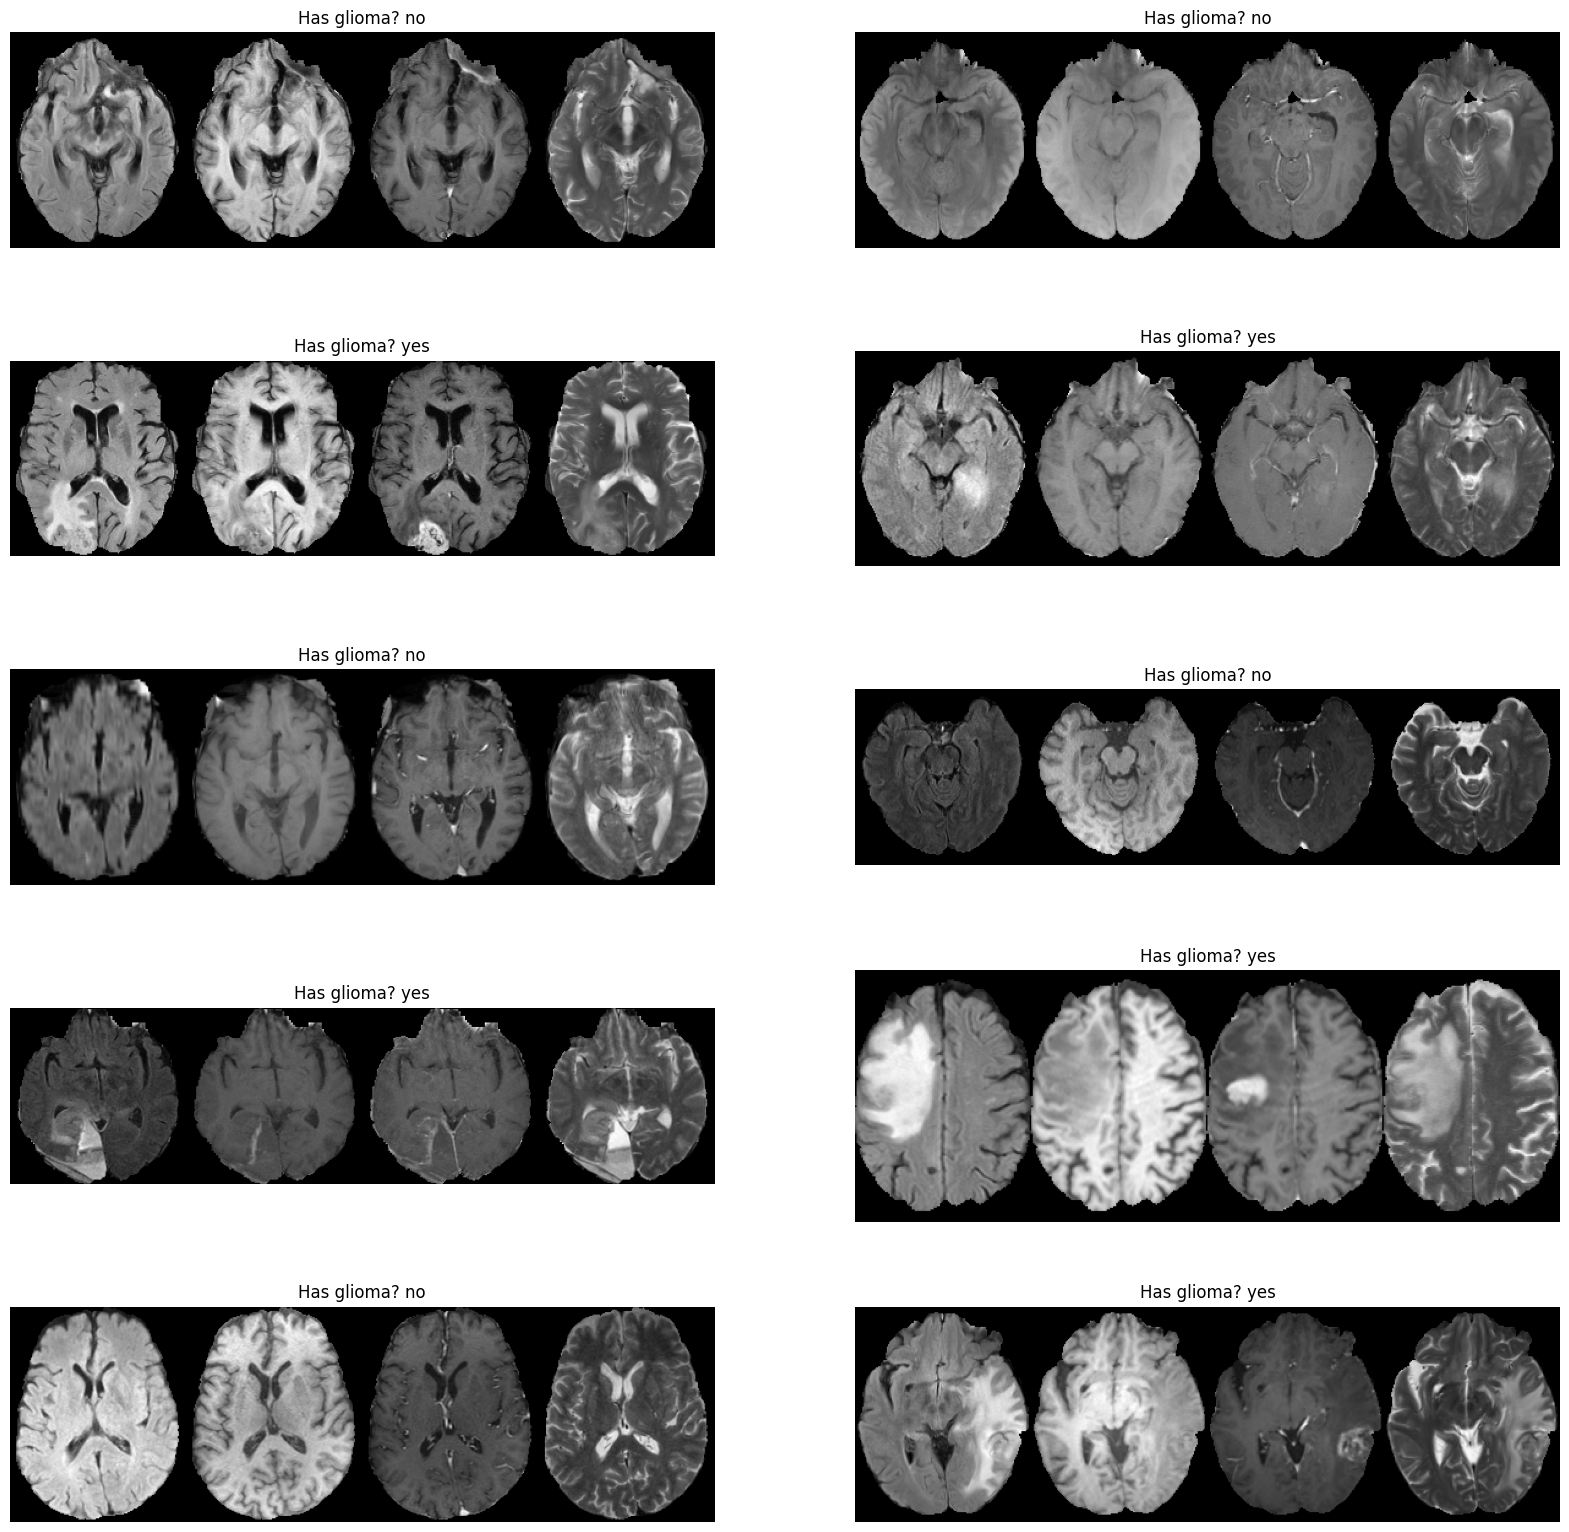

In [9]:
nrow, ncol = 5, 2
num_files = nrow * ncol
files_to_visualize = np.random.choice(train_files, size=num_files, replace=False)
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20), facecolor='white')
for f, ax in zip(files_to_visualize, axes.flatten()):
    data = train_transforms(f)
    # different modalities side by side
    img = np.concatenate(list(data["image"]), axis=1)
    im_show = ax.imshow(img, cmap="gray")
    ax.set_title(f"Has glioma? {['yes', 'no'][data['label'][0]]}")
    ax.axis("off")

**4.Model Creation/Choice & Loss Function**

Note this project utilizes a variety of pre-made models from Monai model zoo, however custom models can be used just ensure dimensions are changed accordingly and appropriate loss functions are used.

In [10]:
# Insert your model here
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2)
model.to(device)

# Insert your loss function here
loss_function = torch.nn.CrossEntropyLoss()

Dense Net 169 selected for this notebook from Monai Model Zoo

In [11]:
# Helper function for inferring during validation
def infer_seg(images, model):
    return model(images).argmax(0)


# use Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**5.Training**

In [12]:
# start a typical PyTorch training
max_epochs = 10
val_interval = 1
best_metric = -1
best_metric_epoch = -1
losses, metrics = [], []

tr = trange(max_epochs)
for epoch in tr:
    epoch_loss = 0

    for batch_data in train_loader:
        inputs, labels = batch_data["image"], batch_data["label"]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = torch.nn.Softmax(dim=1)(outputs)
        loss = loss_function(outputs, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        with eval_mode(model):
            num_correct = 0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["image"], val_data["label"]
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                with torch.no_grad():
                    val_outputs = model(val_images)
                    value = torch.eq(val_outputs.argmax(dim=1), val_labels.argmax(dim=1))
                    metric_count += len(value)
                    num_correct += int(value.sum().item())

            metric = num_correct / metric_count
            metrics.append(metric)

            # If better than current best, save model
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), best_model_path)

    tr.set_description(f"Loss: {epoch_loss:.4f}, best val metric: {best_metric:.4f} at epoch {best_metric_epoch}")

Loss: 0.3890, best val metric: 0.9536 at epoch 9: 100%|██████████| 10/10 [02:34<00:00, 15.43s/it]


Plot loss results

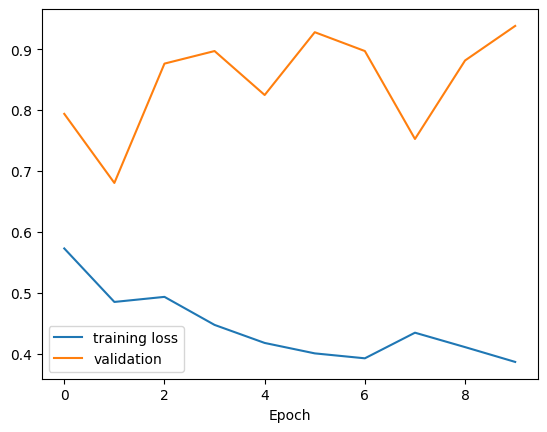

In [35]:
fig, ax = plt.subplots(facecolor='white')
ax.plot(losses, label="training loss")
ax.plot(metrics, label="validation")
ax.set_xlabel("Epoch")
_ = ax.legend()

In [13]:
model.load_state_dict(torch.load(best_model_path))
_ = model.eval()

<ipython-input-13-df4a6896f45c>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Predictions and labels are collected from the validation data set and converted to class indices. These are used to construct a confusion matrix to give us a helpful visual to assess how well our model is doing. This is showing us the proportion of false positives true positives.

100%|██████████| 20/20 [00:05<00:00,  3.89it/s]


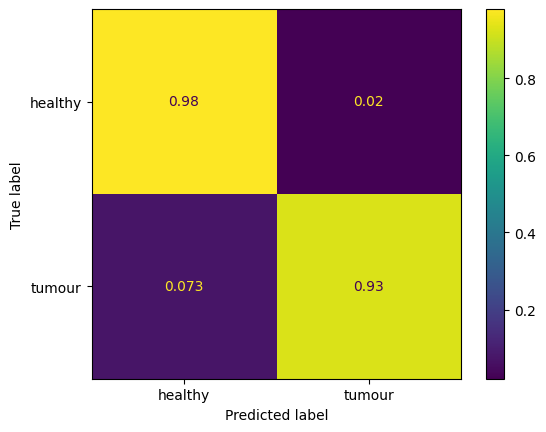

In [14]:
y_pred = torch.tensor([], dtype=torch.float32, device=device)
y = torch.tensor([], dtype=torch.long, device=device)

for data in tqdm(val_loader):
    images, labels = data["image"].to(device), data["label"].to(device)
    outputs = model(images).detach()
    y_pred = torch.cat([y_pred, outputs], dim=0)
    y = torch.cat([y, labels], dim=0)

y_pred = y_pred.argmax(dim=1)
y = y.argmax(dim=1)

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["healthy", "tumour"],
)
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

**6.Interpretability/Analysis**

First create transforms, ensure these match those used for training of the model.

In [15]:
transforms = mt.Compose(
    [
        mt.LoadImaged("image"),
        mt.Rotate90d("image"),
        mt.CropForegroundd("image", source_key="image", k_divisible=16),
        mt.ScaleIntensityd("image", channel_wise=True),
        mt.EnsureTyped(["image", "label"]),
    ]
)


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` was changed in version 1.5 from `allow_smaller=True` to `allow_smaller=False`.
  warn_deprecated(argname, msg, warning_category)


Load in pre-trained network, ensure this model matches that which is used above.

In [16]:
# ensure model matches one used for training
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2)
# load weights
model.load_state_dict(torch.load(best_model_path))
model.to(device)
_ = model.eval()

<ipython-input-16-7c35550f7abc>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


**7. Image Selection**

The code below randomly selects an image infers it's class and visualizes it. Rerun this section each time you want to run saliency analysis on a different image.

Logits: [2.2112364e-16 1.0000000e+00]
Actual class: tumour. Pred class: tumour, prob 100.000%.


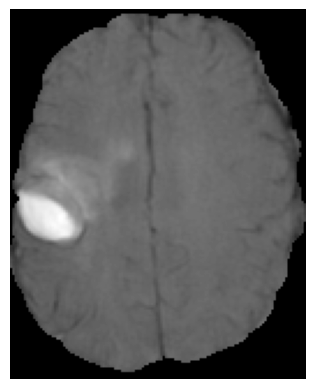

In [17]:
def class_to_str(idx):
    return "healthy" if idx == 0 else "tumour"


# get random file and transform
while True:
    rand_file = np.random.choice(data_dicts)
    data = transforms(rand_file)
    im_t = data["image"][None].to(device)
    im = np.mean(im_t[0].cpu().numpy(), axis=0, keepdims=True)
    #fname = os.path.basename(data["image_meta_dict"]["filename_or_obj"])[:-7]
    gt = data["label"][1]
    gt_str = class_to_str(gt)
    if gt_str == "tumour":
        break

# infer
logits = model(im_t)[0]
logits = torch.nn.functional.softmax(logits, dim=0).detach().cpu().numpy()
pred = logits.argmax(0).item()
pred_str = class_to_str(pred)
prob = logits[pred].item() * 100  # percentage
print(f"Logits: {logits}")
print(f"Actual class: {gt_str}. Pred class: {pred_str}, prob {prob:.3f}%.")

# visualise
plt.figure(facecolor="white")
plt.imshow(im[0], cmap="gray")
#plt.title(f"{fname}")
_ = plt.axis("off")

Saliency

In [18]:
def compare_saliency(img, saliency_map, title, fig=None, ax=None):
    if isinstance(saliency_map, torch.Tensor):
        saliency_map = saliency_map.detach().cpu().numpy()
    if fig is None:
        fig, ax = plt.subplots(1, 1, facecolor='white')
    ax.imshow(img[0], cmap="gray")
    imshow2 = ax.imshow(
        saliency_map, cmap="jet", alpha=(img[0] > 0).astype(np.float32) * 0.5
    )
    fig.colorbar(imshow2, ax=ax)
    ax.axis("off")
    ax.set_title(title)

**Occlusion Sensitivity**

Iteratively blocks off sections of the image and records the resulting changes in certainty of the inferred class. For correct inference blue implies importance. mask_size determines the size of the square that is occluded, you ideally want this to balance this ensuring its not larger than the feature you want to capture but not too small that certainty doesn't change significantly between iterrations. stride is how far the occluded area is shifted between iterrations, lower gives higher resolution with the consequence of greater computing cost.

**GradCam**

This method allows the user to choose a layer of interest and gives the gradient calculated at that point. Using a layer towards the end should give the most information. To get the names of the layers of your model use the following code.

In [44]:
for name, _ in model.named_modules(): print(name)


features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
features.denseblock1.denselayer1
features.denseblock1.denselayer1.layers
features.denseblock1.denselayer1.layers.norm1
features.denseblock1.denselayer1.layers.relu1
features.denseblock1.denselayer1.layers.conv1
features.denseblock1.denselayer1.layers.norm2
features.denseblock1.denselayer1.layers.relu2
features.denseblock1.denselayer1.layers.conv2
features.denseblock1.denselayer2
features.denseblock1.denselayer2.layers
features.denseblock1.denselayer2.layers.norm1
features.denseblock1.denselayer2.layers.relu1
features.denseblock1.denselayer2.layers.conv1
features.denseblock1.denselayer2.layers.norm2
features.denseblock1.denselayer2.layers.relu2
features.denseblock1.denselayer2.layers.conv2
features.denseblock1.denselayer3
features.denseblock1.denselayer3.layers
features.denseblock1.denselayer3.layers.norm1
features.denseblock1.denselayer3.layers.relu1
features.denseblock1.denselayer3.layers.conv1


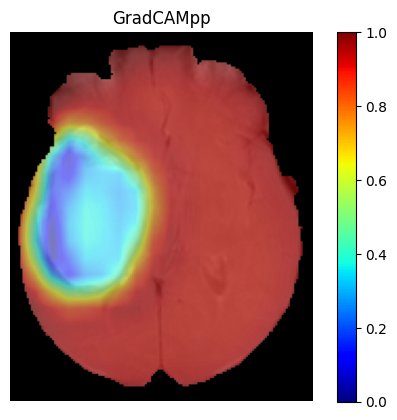

In [ ]:
target_layer = "features.transition2.relu"
gradcampp = GradCAMpp(model, target_layers=target_layer)

# GradCAM
out_cam_pp = gradcampp(x=im_t, class_idx=pred)[0, 0]
compare_saliency(im, out_cam_pp, "GradCAMpp")

**Extensions of VanillaGrad**

The following are extensions of VanillaGrad which computes the gradient of the class score function with respect to the input image. Note the colors are inversed here and red implies importance.

**SmoothGrad**

Smoothgrad repeatedly adds noise to the input image and performs VanillaGrad and averages the results. The default number of repeats is 25 and can be changed by changing the number following n_samples. Red indicates importance here as well.

Computing SmoothGrad: 100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


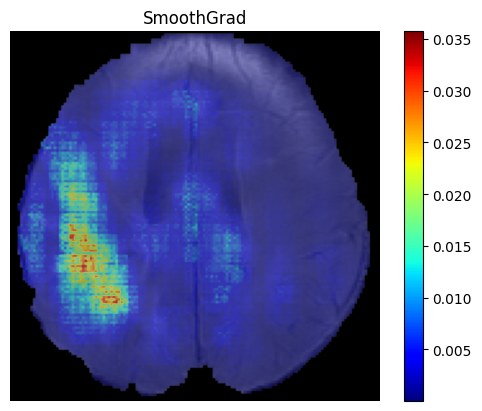

In [45]:
smooth_grad = SmoothGrad(model, n_samples=25, magnitude=True, stdev_spread=0.04)
out_smooth_grad = smooth_grad(im_t)[0].cpu().numpy()
# average across four input channels
out_smooth_grad = np.mean(out_smooth_grad, 0)
compare_saliency(im, out_smooth_grad, "SmoothGrad")

**GuidedVanilla**

**Note on Guided**:In theory overriding ReLU for will allow for a clearer more concise image of importance as despite ReLU ommitting/suppressing negatives on forward passes, the standard gradient method negative gradients coming into a ReLU layer are allowed to back propogate leading to noise on the saliency map.

Computes the gradient of the target output with respect to input, but gradients of ReLU functions are overidden so that only non-negative gradients are back propogated. Red indicates importance here as well.

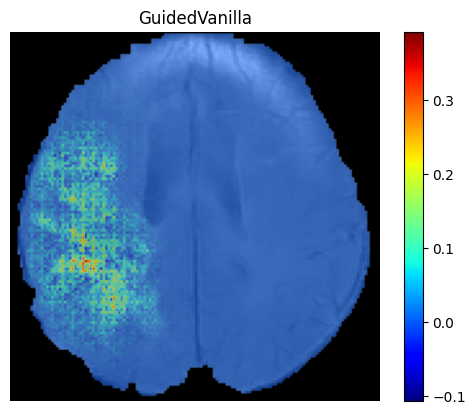

In [46]:
guided_vanilla = GuidedBackpropGrad(model)
out_guided_vanilla = guided_vanilla(im_t)[0].cpu().numpy()
# average across four input channels
out_guided_vanilla = np.mean(out_guided_vanilla, 0)
compare_saliency(im, out_guided_vanilla, "GuidedVanilla")

**GuidedSmooth**

The same as GuidedVanilla but working off of SmoothGrad instead of Vanilla as a basis. Red indicates importance here as well.

Computing GuidedBackpropSmoothGrad: 100%|██████████| 25/25 [00:03<00:00,  7.59it/s]


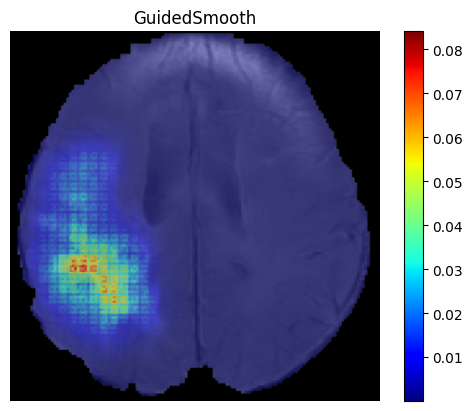

In [47]:
guided_smooth = GuidedBackpropSmoothGrad(model)
out_guided_smooth = guided_smooth(im_t)[0].cpu().numpy()
# average across four input channels
out_guided_smooth = np.mean(out_guided_smooth, 0)
compare_saliency(im, out_guided_smooth, "GuidedSmooth")